# Programming exercise 4: Neural networks learning
Here are my solutions for this exercise on neural networks learning (backpropagation algorithm). Jupyter notebook template modified from: https://github.com/dibgerge/ml-coursera-python-assignments.

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt

## 1 Neural networks

### 1.1 Visualizing the data

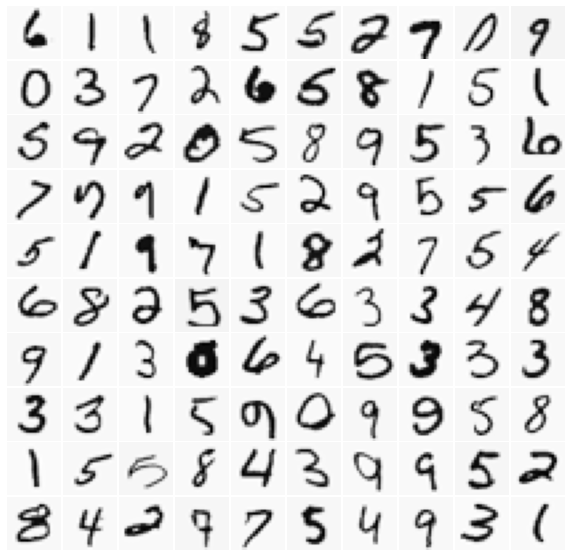

In [4]:
# Read data
data = sio.loadmat('ex4data1.mat')
X, y = data['X'], data['y'].ravel()

# Initialize important variables
m, n = X.shape

# Select a random training sets for visualization
rand_indices = np.random.choice(m, 100, replace=False)
X_vis = X[rand_indices, :]

In [3]:
def displayData(X, example_width=None, figsize=(10, 10)):
    
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None] # Promote to 2D array
    else:
        raise IndexError('Input should be 1D or 2D')
    
    example_width = example_width or int(np.round(np.sqrt(n))) #20x20 pixels
    example_height = n / example_width
    
    # Compute number of images to display
    display_row = int(np.floor(np.sqrt(m)))
    display_col = int(np.ceil(m / display_row))
    
    fig, ax_array = plt.subplots(display_row, display_col, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    
    ax_array = [ax_array] if m == 1 else ax_array.ravel()
    
    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys',
                  extent=[0, 1, 0, 1])
        ax.axis('off')

displayData(X_vis)

### 1.2 Model representation

In [5]:
# Load weights
data = sio.loadmat('ex4weights.mat')
theta_1, theta_2 = data['Theta1'], data['Theta2']
print (f'theta_1 has a size of {theta_1.shape}')
print (f'theta_2 has a size of {theta_2.shape}')

theta_1 has a size of (25, 401)
theta_2 has a size of (10, 26)


In [6]:
# Setup the parameters for this exercise
input_layer_size = 400         # 20x20 input units of digits
hidden_layer_size = 25         # 25 hidden units
num_labels = len(np.unique(y)) # 10 labels, from 0 to 9

# Unroll parameters
nn_params = np.concatenate([theta_1.ravel(), theta_2.ravel()])

### 1.3 Feedforward and cost function

In [7]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    
    """

    g = 1 / (1 + np.exp(-z))
    
    return g

In [12]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
        
    """
    
    # Initialize important variables
    m = X.shape[0]
    num_labels = len(np.unique(y))
    
    # Initialize bias unit
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    # Recode labels as vectors containing 0 or 1
    y_vec = np.zeros((m, num_labels))
    for index, value in enumerate(y):
        y_vec[index, value - 1] = 1
    
# -------- Reshape nn_params ---------- #
    theta_1_val = (input_layer_size + 1) * hidden_layer_size
    theta_1 = nn_params[:theta_1_val].reshape(hidden_layer_size,
                                              (input_layer_size + 1))
    theta_2 = nn_params[theta_1_val:].reshape(num_labels,
                                              (hidden_layer_size + 1))
    
# -------- Forward propagation ---------- #
    # Activation layer 2 calculation
    z2 = X.dot(theta_1.T)
    a2 = sigmoid(z2)
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
    
    # Activation layer 3 calulation (output layer)
    z3 = a2.dot(theta_2.T)
    a3 = sigmoid(z3)

# -------- Cost function ---------- #
    J = 0
    for i in range(m):
        term_1 = -y_vec[i, ].T.dot(np.log(a3[i, ]))
        term_2 = (1 - y_vec[i, ]).T.dot(np.log(1 - a3[i, ]))        
        J += term_1 - term_2
    J = (1 / m) * J
    
    # Regularization of cost function
    reg_theta_1 = np.sum(np.square(theta_1[:, 1:]))
    reg_theta_2 = np.sum(np.square(theta_2[:, 1:]))
    reg = (lambda_ / (2 * m)) * (reg_theta_1 + reg_theta_2)
    J = J + reg
    
# -------- Gradient descent ---------- #
    grad = 0
    
    # Delta 3 calculation
    delta_3 = a3 - y_vec
    accumulate_2 = delta_3.T.dot(a2)
    
    # Delta 2 calculation
    z2 = np.concatenate([np.ones((m, 1)), z2], axis=1)
    delta_2 = theta_2.T.dot(delta_3.T).T * sigmoidGradient(z2)
    delta_2 = delta_2[:, 1:]
    accumulate_1 = delta_2.T.dot(X)
    
    
    theta_1_grad = accumulate_1 * (1 / m)
    theta_1_grad[:, 1:] += (lambda_ / m) * theta_1[:, 1:]
    
    theta_2_grad = accumulate_2 * (1 / m)
    theta_2_grad[:, 1:] += (lambda_ / m) * theta_2[:, 1:]
        
    grad = np.concatenate([theta_1_grad.ravel(),
                           theta_2_grad.ravel()])
    return J, grad

Call your nnCostFunction using the loaded set of parameters for `theta_1`and `theta_2`. The cost should be about 0.287629.

In [13]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


In [14]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


## 2 Backpropagation

This section will be my implementation of the backpropagation algorithm to learn the parameters of the neural network. Code for backpropagation is found in `nnCostFunction`.

### 2.1 Sigmoid gradient

The gradient for the sigmoid function can be computed as
$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where
$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

The implementation of `sigmoidGradient` is in the following cell. 

In [15]:
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    This should work regardless if z is a matrix or a vector. 
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    
    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z.
        
    """
    
    g = 1 / (1 + np.exp(-z))
    g_prime = g * (1 - g)
    
    return g_prime

In [16]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


### 2.2 Random initialization

In [17]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
    """
    
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    
    return W

In [18]:
print ('Initializing neural network parameters ...')
initial_theta_1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta_2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_theta_1.ravel(),
                                    initial_theta_2.ravel()], axis=0)

Initializing neural network parameters ...


### 2.3 Backpropagation
Vectorized approach for backpropagation is presented in the `nnCostFunction`. The following image represents the neural network for backpropagation.
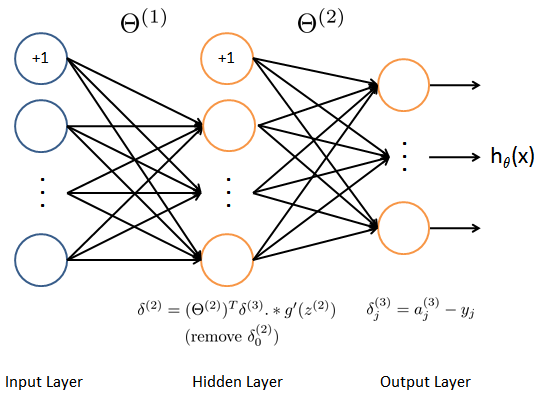

### 2.4 Gradient checking
Numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:
$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$



In [19]:
def checkNNGradients(nnCostFunction, lambda_=0):
    """
    Creates a small neural network to check the backpropagation gradients. It will output the
    analytical gradients produced by your backprop code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result in
    very similar values.
    Parameters
    ----------
    nnCostFunction : func
        A reference to the cost function implemented by the student.
    lambda_ : float (optional)
        The regularization parameter value.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two the solutions. If you have a correct
    # implementation, and assuming you used e = 0.0001 in computeNumericalGradient, then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    print('If your backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n'
          'Relative Difference: %g' % diff)


In [20]:
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.
    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.
    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.
    e : float (optional)
        The value to use for epsilon for computing the finite difference.
    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad

In [21]:
def debugInitializeWeights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in incoming connections and fan_out outgoings
    connections using a fixed strategy. This will help you later in debugging.
    Note that W should be set a matrix of size (1+fan_in, fan_out) as the first row of W handles
    the "bias" terms.
    Parameters
    ----------
    fan_out : int
        The number of outgoing connections.
    fan_in : int
        The number of incoming connections.
    Returns
    -------
    W : array_like (1+fan_in, fan_out)
        The initialized weights array given the dimensions.
    """
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W

In [27]:
#  Check gradients by running checkNNGradients
lambda_ = 3
checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

[[-6.89656094e-03 -6.89656094e-03]
 [-1.68267828e-02 -1.68267828e-02]
 [-6.03852835e-02 -6.03852835e-02]
 [-1.74312602e-02 -1.74312602e-02]
 [ 7.67737085e-03  7.67737086e-03]
 [ 3.94790739e-02  3.94790739e-02]
 [-3.18506140e-02 -3.18506140e-02]
 [-5.75487035e-02 -5.75487035e-02]
 [-8.32291332e-03 -8.32291333e-03]
 [ 5.93042219e-02  5.93042218e-02]
 [ 2.49147431e-02  2.49147431e-02]
 [-4.51694809e-02 -4.51694809e-02]
 [ 8.77682038e-03  8.77682039e-03]
 [ 2.47802910e-02  2.47802910e-02]
 [ 5.96765902e-02  5.96765902e-02]
 [ 9.07569301e-03  9.07569301e-03]
 [-9.05665002e-03 -9.05665003e-03]
 [-3.26888410e-02 -3.26888410e-02]
 [ 3.88367675e-02  3.88367675e-02]
 [ 5.47218857e-02  5.47218857e-02]
 [ 1.14544970e-01  1.14544970e-01]
 [ 1.39805346e-02  1.39805346e-02]
 [ 9.90274164e-02  9.90274164e-02]
 [ 2.50391490e-02  2.50391490e-02]
 [ 8.05873169e-02  8.05873169e-02]
 [ 3.75428084e-02  3.75428084e-02]
 [ 1.11056588e-01  1.11056588e-01]
 [ 2.73657452e-05  2.73657470e-05]
 [ 1.17245562e-01  1

### 2.5 Learning parameters using `scipy.optimize.minimize`

In [28]:
options = {'maxiter': 100}
lambda_ = 1

# creation of 'short hand' for cost function be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Cost function as single argument
result = optimize.minimize(costFunction,
                           initial_nn_params,
                          jac=True,
                          method='TNC',
                          options=options)

# Solutions for optimization
nn_params = result.x

# Obtain Theta 1 and Theta 2 from nn_params
theta_1 = nn_params[:(hidden_layer_size * (input_layer_size + 1))].reshape(hidden_layer_size, (input_layer_size + 1))
theta_2 = nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape(num_labels, (hidden_layer_size + 1))

In [31]:
def predict(theta_1, theta_2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(theta_1, theta_2)
    """
    
    # Initialize important variables
    m = X.shape[0]
    num_labels = len(np.unique(y))
    
    # Initialize bias unit
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    z2 = X.dot(theta_1.T)
    a2 = sigmoid(z2)
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
    
    z3 = a2.dot(theta_2.T)
    a3 = sigmoid(z3)
    
    predict = np.argmax(a3, axis=1)

    # The theta_1 and theta_2 are loaded from Matlab data, in which the matrix index starts from 1.
    predict += 1
    
    return predict

In [32]:
pred = predict(theta_1, theta_2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 96.520000
